---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---

# Hyperparameter Tuning with PyTorch Lightning {#sec-hyperparameter-tuning-with-pytorch-lightning-601}

## Basic Setup {#sec-basic-setup-601}

This section provides an overview of the hyperparameter tuning process using `spotpython` and `PyTorch` Lightning. It uses the `Diabetes` data set (see @sec-a-05-diabetes-data-set) for a regression task. 
@sec-light-user-data-601 describes how user data can be used in the hyperparameter tuning process.
@sec-light-user-model-601 explains how user models can be used in the hyperparameter tuning process.

In [1]:
#| echo: false
#| label: 601_imports


In this section, we will show how `spotpython` can be integrated into the `PyTorch` Lightning
training workflow for a regression task.
It demonstrates how easy it is to use `spotpython` to tune hyperparameters for a `PyTorch` Lightning model.

After importing the necessary libraries, the `fun_control` dictionary is set up via the `fun_control_init` function.
The `fun_control` dictionary contains

* `PREFIX`: a unique identifier for the experiment
* `fun_evals`: the number of function evaluations
* `max_time`: the maximum run time in minutes
* `data_set`: the data set. Here we use the `Diabetes` data set that is provided by `spotpython`.
* `core_model_name`: the class name of the neural network model. This neural network model is provided by `spotpython`.
* `hyperdict`: the hyperparameter dictionary. This dictionary is used to define the hyperparameters of the neural network model. It is also provided by `spotpython`.
* `_L_in`: the number of input features. Since the `Diabetes` data set has 10 features, `_L_in` is set to 10.
* `_L_out`: the number of output features. Since we want to predict a single value, `_L_out` is set to 1.

The method `set_hyperparameter` allows the user to modify default hyperparameter settings. Here we set the `initialization` method to `["Default"]`. No other initializations are used in this experiment.
The `HyperLight` class is used to define the objective function `fun`. It connects the `PyTorch` and the `spotpython` methods and is provided by `spotpython`.
Finally, a `Spot` object is created.

In [2]:
#| label: 601_setup
import os
import numpy as np
from math import inf
import warnings
from spotpython.data.diabetes import Diabetes
from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import gen_design_table
from spotpython.hyperparameters.values import set_hyperparameter
from spotpython.spot import spot
from spotpython.utils.file import get_experiment_filename

warnings.filterwarnings("ignore")

PREFIX="601"

data_set = Diabetes()

fun_control = fun_control_init(
    save_experiment=True,
    PREFIX=PREFIX,
    TENSORBOARD_CLEAN=False,
    tensorboard_log=False,
    fun_evals=inf,
    max_time=1,
    data_set = data_set,
    core_model_name="light.regression.NNLinearRegressor",
    hyperdict=LightHyperDict,
    _L_in=10,
    _L_out=1)

set_hyperparameter(fun_control, "optimizer", [
                "Adadelta",
                "Adagrad",
                "Adam",
                "AdamW",
                "Adamax",
            ])

set_hyperparameter(fun_control, "l1", [3,9])
set_hyperparameter(fun_control, "epochs", [3,5])
set_hyperparameter(fun_control, "batch_size", [4,11])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
# set_hyperparameter(fun_control, "lr_mult", [0.01, 20.0])
set_hyperparameter(fun_control, "patience", [2,3])

design_control = design_control_init(init_size=10)
fun = HyperLight().fun
spot_tuner = spot.Spot(fun=fun,fun_control=fun_control, design_control=design_control)

Seed set to 123
Seed set to 123


module_name: light
submodule_name: regression
model_name: NNLinearRegressor


In [3]:
#| label: 601_save_experiment
print(gen_design_table(fun_control))

filename = get_experiment_filename(fun_control["PREFIX"])
# if userExperimnents directory does not exist, create it
if not os.path.exists("userExperiment"):
    os.makedirs("userExperiment")
filename = os.path.join("userExperiment", filename)
if spot_tuner.spot_writer is not None:
    spot_tuner.spot_writer.close()
# remove attribute spot_writer from spot_tuner object
if hasattr(spot_tuner, "spot_writer"):
    delattr(spot_tuner, "spot_writer")
# So the experiment, so that it ccan be executed on a remote machine
spot_tuner.save_experiment(filename=filename, overwrite=False)

| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |     3   |   9     | transform_power_2_int |
| epochs         | int    | 4         |     3   |   5     | transform_power_2_int |
| batch_size     | int    | 4         |     4   |  11     | transform_power_2_int |
| act_fn         | factor | ReLU      |     0   |   5     | None                  |
| optimizer      | factor | SGD       |     0   |   4     | None                  |
| dropout_prob   | float  | 0.01      |     0   |   0.025 | None                  |
| lr_mult        | float  | 1.0       |     0.1 |  10     | None                  |
| patience       | int    | 2         |     2   |   3     | transform_power_2_int |
| batch_norm     | factor | 0         |     0   |   1     | None                  |
| initialization | factor | Default   |     0   |   4     | None            

Calling the method `run()` starts the hyperparameter tuning process.

In [4]:
#| label: 601_run
res = spot_tuner.run()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Milestones: [2, 4, 6]



  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 1.6 K  | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estima

train_model result: {'val_loss': 24065.71875, 'hp_metric': 24065.71875}
Milestones: [8, 16, 24]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 5088.82080078125, 'hp_metric': 5088.82080078125}
Milestones: [8, 16, 24]



  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 5.4 K  | train | [256, 10] | [256, 1] 
----------------------------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 23845.181640625, 'hp_metric': 23845.181640625}
Milestones: [2, 4, 6]



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 20.8 K | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
20.8 K    Trainable params
0         Non-trainable params
20.8 K    Total params
0.083     Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 595    | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
595       Trainable params
0         Non-trainable params
595       Total params
0.002     Total estimated model params size (MB)
33        Module

train_model result: {'val_loss': 24096.35546875, 'hp_metric': 24096.35546875}
Milestones: [4, 8, 12]
train_model result: {'val_loss': 23958.287109375, 'hp_metric': 23958.287109375}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 296 K  | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.186     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 16987.45703125, 'hp_metric': 16987.45703125}
spotpython tuning: 5088.82080078125 [#---------] 12.14% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 23775.63671875, 'hp_metric': 23775.63671875}
spotpython tuning: 5088.82080078125 [##--------] 20.70% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 5.9 K  | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.023     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


Milestones: [8, 16, 24]
train_model result: {'val_loss': 24087.63671875, 'hp_metric': 24087.63671875}
spotpython tuning: 5088.82080078125 [###-------] 25.83% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Milestones: [4, 8, 12]


`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 24059.75, 'hp_metric': 24059.75}
spotpython tuning: 5088.82080078125 [###-------] 30.67% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 300 K  | train | [256, 10] | [256, 1] 
----------------------------------------------------------------------
300 K     Trainable params
0         Non-trainable params
300 K     Total params
1.201     Total estimated model params size (MB)
93        Modules in train mode
0         Modules in eval mode


Milestones: [4, 8, 12]
train_model result: {'val_loss': 24047.888671875, 'hp_metric': 24047.888671875}
spotpython tuning: 5088.82080078125 [###-------] 33.79% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [256, 10] | [256, 1] 
----------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 23890.083984375, 'hp_metric': 23890.083984375}
spotpython tuning: 5088.82080078125 [####------] 38.60% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Milestones: [8, 16, 24]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 5.9 K  | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.023     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': nan, 'hp_metric': nan}
Milestones: [4, 8, 12]
train_model result: {'val_loss': 24083.171875, 'hp_metric': 24083.171875}
spotpython tuning: 5088.82080078125 [#####-----] 45.70% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Milestones: [4, 8, 12]



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 22681.7265625, 'hp_metric': 22681.7265625}
spotpython tuning: 5088.82080078125 [#####-----] 48.50% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 12290.765625, 'hp_metric': 12290.765625}
spotpython tuning: 5088.82080078125 [######----] 57.88% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Milestones: [8, 16, 24]



  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 296 K  | train | [16, 10] | [16, 1]  
---------------------------------------------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.186     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 22651.03125, 'hp_metric': 22651.03125}
spotpython tuning: 5088.82080078125 [#########-] 86.75% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 5.4 K  | train | [1024, 10] | [1024, 1]
-----------------------------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 24022.009765625, 'hp_metric': 24022.009765625}
spotpython tuning: 5088.82080078125 [#########-] 91.18% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Milestones: [4, 8, 12]


`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 24049.912109375, 'hp_metric': 24049.912109375}
spotpython tuning: 5088.82080078125 [##########] 95.05% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Milestones: [8, 16, 24]
train_model result: {'val_loss': 5110.88037109375, 'hp_metric': 5110.88037109375}
spotpython tuning: 5088.82080078125 [##########] 100.00% Done...

Experiment saved to spot_601_experiment.pickle


## Looking at the Results

### Tuning Progress

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized with `spotpython`'s method `plot_progress`. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.

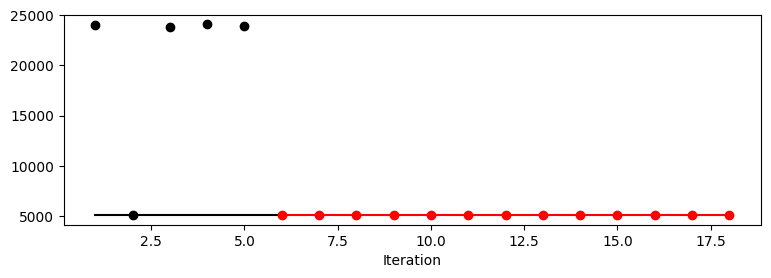

In [5]:
spot_tuner.plot_progress()

### Tuned Hyperparameters and Their Importance

Results can be printed in tabular form.

In [6]:
from spotpython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name           | type   | default   |   lower |   upper | tuned                | transform             |   importance | stars   |
|----------------|--------|-----------|---------|---------|----------------------|-----------------------|--------------|---------|
| l1             | int    | 3         |     3.0 |     9.0 | 8.0                  | transform_power_2_int |         0.20 | .       |
| epochs         | int    | 4         |     3.0 |     5.0 | 5.0                  | transform_power_2_int |        23.68 | *       |
| batch_size     | int    | 4         |     4.0 |    11.0 | 6.0                  | transform_power_2_int |         0.00 |         |
| act_fn         | factor | ReLU      |     0.0 |     5.0 | Swish                | None                  |         0.25 | .       |
| optimizer      | factor | SGD       |     0.0 |     4.0 | Adadelta             | None                  |         0.00 |         |
| dropout_prob   | float  | 0.01      |     0.0 |   0.025 | 0.00685029897705

A histogram can be used to visualize the most important hyperparameters.

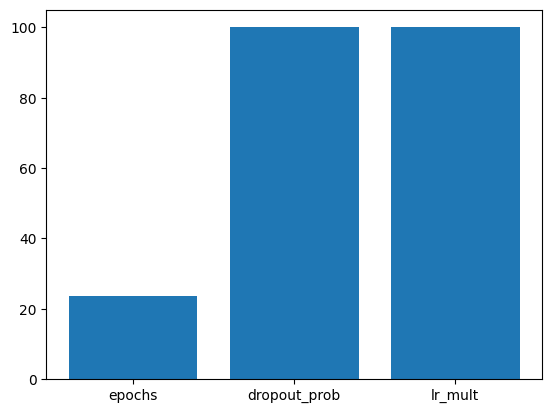

In [7]:
spot_tuner.plot_importance(threshold=1.0)

l1:  0.19577501679709777
epochs:  23.680528314750788
batch_size:  0.001
act_fn:  0.24685936765061567
optimizer:  0.001
dropout_prob:  100.0
lr_mult:  100.0
patience:  0.001
batch_norm:  0.001
initialization:  0.001
impo: [['l1', 0.19577501679709777], ['epochs', 23.680528314750788], ['batch_size', 0.001], ['act_fn', 0.24685936765061567], ['optimizer', 0.001], ['dropout_prob', 100.0], ['lr_mult', 100.0], ['patience', 0.001], ['batch_norm', 0.001], ['initialization', 0.001]]
indices: [5, 6, 1, 3, 0, 2, 4, 7, 8, 9]
indices after max_imp selection: [5, 6, 1]


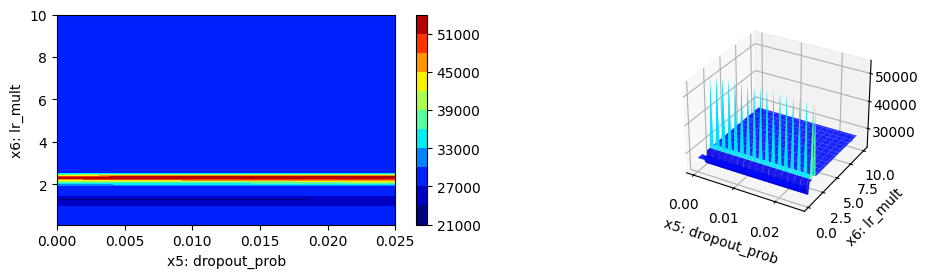

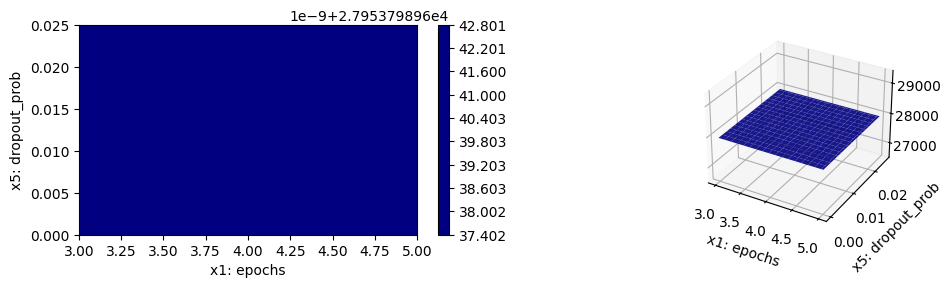

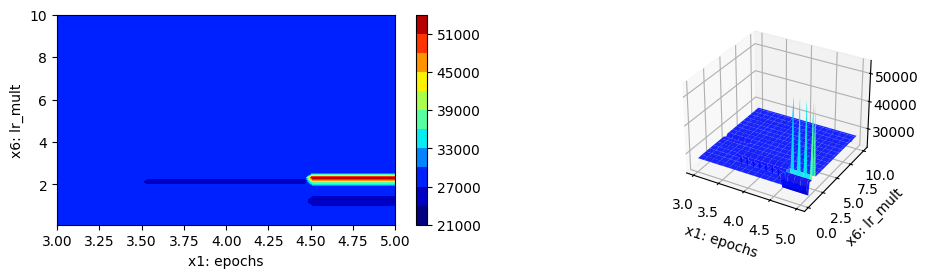

In [8]:
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

### Get the Tuned Architecture {#sec-get-spot-results-31}

In [9]:
import pprint
from spotpython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
pprint.pprint(config)

{'act_fn': Swish(),
 'batch_norm': False,
 'batch_size': 64,
 'dropout_prob': 0.006850298977051597,
 'epochs': 32,
 'initialization': 'xavier_normal',
 'l1': 256,
 'lr_mult': 2.2237336281201694,
 'optimizer': 'Adadelta',
 'patience': 8}


* Test on the full data set

In [10]:
# set the value of the key "TENSORBOARD_CLEAN" to True in the fun_control dictionary and use the update() method to update the fun_control dictionary
fun_control.update({"TENSORBOARD_CLEAN": True})
fun_control.update({"tensorboard_log": True})


In [11]:
import os
import pickle

def chk_pickle(s):
    # Construct the filename
    filename = s + '.pickle'

    # Check if the file exists
    return os.path.isfile(filename)

In [12]:
from spotpython.light.testmodel import test_model
from spotpython.light.loadmodel import load_light_from_checkpoint
from spotpython.utils.init import get_feature_names


if chk_pickle("model_loaded_" + PREFIX):
    with open("model_loaded_" + PREFIX + ".pickle", "rb") as f:
        model_loaded = pickle.load(f)
else:
    test_model(config, fun_control)
    model_loaded = load_light_from_checkpoint(config, fun_control)
    # save model_loaded to pickle file
    with open("model_loaded_" + PREFIX + ".pickle", "wb") as f:
        pickle.dump(model_loaded, f)

get_feature_names(fun_control)



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.
Restoring states from the checkpoint path at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/256_32_64_Swish_Adadelta_0.0069_2.2237_8_False_xavier_normal_TEST/last.ckpt
Loaded model weights from the checkpoint at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/256_32_64_Swish_Adadelta_0.0069_2.2237_8_False_xavier_normal_TEST/last.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      30447.068359375      │
│         val_loss          │      30447.068359375      │
└───────────────────────────┴───────────────────────────┘

test_model result: {'val_loss': 30447.068359375, 'hp_metric': 30447.068359375}
config: {'l1': 256, 'epochs': 32, 'batch_size': 64, 'act_fn': Swish(), 'optimizer': 'Adadelta', 'dropout_prob': 0.006850298977051597, 'lr_mult': 2.2237336281201694, 'patience': 8, 'batch_norm': False, 'initialization': 'xavier_normal'}
Loading model with 256_32_64_Swish_Adadelta_0.0069_2.2237_8_False_xavier_normal_TEST from runs/saved_models/256_32_64_Swish_Adadelta_0.0069_2.2237_8_False_xavier_normal_TEST/last.ckpt
Model: NNLinearRegressor(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): Swish()
    (2): Dropout(p=0.006850298977051597, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Swish()
    (5): Dropout(p=0.006850298977051597, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Swish()
    (8): Dropout(p=0.006850298977051597, inplace=False)
    (9): Linear(in_features=128, out_features=6

['age',
 'sex',
 'bmi',
 'bp',
 's1_tc',
 's2_ldl',
 's3_hdl',
 's4_tch',
 's5_ltg',
 's6_glu']

## Cross Validation With Lightning

* The `KFold` class from `sklearn.model_selection` is used to generate the folds for cross-validation.
* These mechanism is used to generate the folds for the final evaluation of the model.
* The `CrossValidationDataModule` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/data/lightcrossvalidationdatamodule.py) is used to generate the folds for the hyperparameter tuning process.
* It is called from the `cv_model` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/light/cvmodel.py).

In [13]:
config

{'l1': 256,
 'epochs': 32,
 'batch_size': 64,
 'act_fn': Swish(),
 'optimizer': 'Adadelta',
 'dropout_prob': 0.006850298977051597,
 'lr_mult': 2.2237336281201694,
 'patience': 8,
 'batch_norm': False,
 'initialization': 'xavier_normal'}

In [14]:
from spotpython.light.cvmodel import cv_model
from spotpython.hyperparameters.values import set_control_key_value
set_control_key_value(control_dict=fun_control,
                        key="k_folds",
                        value=2,
                        replace=True)
set_control_key_value(control_dict=fun_control,
                        key="test_size",
                        value=0.6,
                        replace=True)
cv_model(config, fun_control)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


k: 0
Train Dataset Size: 221
Val Dataset Size: 221
Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 75.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 18314.8515625, 'hp_metric': 18314.8515625}
k: 1
Train Dataset Size: 221
Val Dataset Size: 221
Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 25990.4375, 'hp_metric': 25990.4375}


22152.64453125

## Extending the Basic Setup

This basic setup can be adapted to user-specific needs in many ways. For example, the user can specify a custom data set, a custom model, or a custom loss function.
The following sections provide more details on how to customize the hyperparameter tuning process.
Before we proceed, we will provide an overview of the basic settings of the hyperparameter tuning process and explain the parameters used so far.

### General Experiment Setup {#sec-general-experiment-setup-601}

To keep track of the different experiments, we use a `PREFIX` for the experiment name. The `PREFIX` is used to create a unique experiment name. The `PREFIX` is also used to create a unique TensorBoard folder, which is used to store the TensorBoard log files.

`spotpython` allows the specification of two different types of stopping criteria: first, the number of function evaluations (`fun_evals`), and second, the maximum run time in seconds (`max_time`). Here, we will set the number of function evaluations to infinity and the maximum run time to one minute.

`max_time` is set to one minute for demonstration purposes. For real experiments, this value should be increased.
Note,  the total run time may exceed the specified `max_time`, because the initial design is always evaluated, even if this takes longer than `max_time`.


### Data Setup {#sec-data-601}

Here, we have provided the `Diabetes` data set class, which is a subclass of `torch.utils.data.Dataset`. 
Data preprocessing is handled by `Lightning` and `PyTorch`. It is described in the [LIGHTNINGDATAMODULE](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) documentation. 

The data splitting, i.e., the generation of training, validation, and testing data, is handled by `Lightning`.


### Objective Function `fun` {#sec-the-objective-function-31}

The objective function `fun` from the class `HyperLight` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/fun/hyperlight.py) is selected next. It implements an interface from `PyTorch`'s training, validation, and testing methods to `spotpython`.

### Core-Model Setup

By using `core_model_name = "light.regression.NNLinearRegressor"`, the `spotpython` model class `NetLightRegression` [[SOURCE]](https://sequential-parameter-optimization.github.io/spotpython/reference/spotpython/light/regression/netlightregression/) from the `light.regression` module is selected.

### Hyperdict Setup

For a given `core_model_name`, the corresponding hyperparameters are automatically loaded from the associated dictionary, which is stored as a JSON file. The JSON file contains hyperparameter type information, names, and bounds. For `spotpython` models, the hyperparameters are stored in the `LightHyperDict`, see [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/hyperdict/light_hyper_dict.json)
Alternatively, you can load a local hyper_dict.
The `hyperdict`  uses the default hyperparameter settings. These can be modified as described in @sec-modifying-hyperparameter-levels.

### Other Settings {#sec-other-settings-601}

There are several additional parameters that can be specified, e.g., since we did not specify a loss function, `mean_squared_error` is used, which is the default loss function. These will be explained in more detail in the following sections.


## Tensorboard {#sec-tensorboard-601}

The textual output shown in the console (or code cell) can be visualized with Tensorboard, if the argument `tensorboard_log` to `fun_control_init()` is set to `True`. The Tensorboard log files are stored in the `runs` folder. To start Tensorboard, run the following command in the terminal:


```{raw}
tensorboard --logdir="runs/"
```

Further information can be found in the [PyTorch Lightning documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.tensorboard.html) for Tensorboard.

## Loading the Saved Experiment and Getting the Hyperparameters of the Tuned Model

To get the tuned hyperparameters as a dictionary, the `get_experiment_from_PREFIX` function can be used.

In [15]:
from spotpython.utils.file import get_experiment_from_PREFIX
config = get_experiment_from_PREFIX("601")["config"]
config

{'l1': 256,
 'epochs': 32,
 'batch_size': 64,
 'act_fn': Swish(),
 'optimizer': 'Adadelta',
 'dropout_prob': 0.006850298977051597,
 'lr_mult': 2.2237336281201694,
 'patience': 8,
 'batch_norm': False,
 'initialization': 'xavier_normal'}

## Using the `spotgui`

The `spotgui` [[github]](https://github.com/sequential-parameter-optimization/spotGUI) provides a convenient way to interact with the hyperparameter tuning process.
To obtain the settings from @sec-summary-setting-up-the-experiment-601, the `spotgui` can be started as shown in @fig-spotgui.

![spotgui](./figures_static/024_gui.png){width=100% #fig-spotgui}

## Summary

This section presented an introduction to the basic setup of hyperparameter tuning with `spotpython` and `PyTorch` Lightning.